# **3. Ajustes y regresiones**

En esta guía vas a encontrar herramientas básicas para efectuar *estimaciones de parámetros* de tus modelos. Esto se hará mediante el ajuste (regresión) lineal o no lineal de tus parámetros que minimize las diferencias entre las predicciones de tu modelo y tus observaciones.

Junto con las bibliotecas usuales se agrega la funcionalidad `curve_fit` de `scipy.optimize` que permitirá sistematizar los ajustes.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

## 3.1. Modelo y observaciones

A la hora de efectuar un análisis por regresión (ajuste) tenés que poner en claro qué objetivo te lleva a realizarlo.

Suponé que tenés un conjunto de $n$ pares de valores experimentales $(X_n,Y_n)$ tales que, por ejemplo, $X:=L$ represente la longitud e $Y:=T$ el periodo de un péndulo. También suponé que existe cierta relación funcional $Y(X)$, que puede ser conocida o no.

Si la relación funcional no es conocida, un objetivo posible es intentar estudiar qué *modelo* $Y(X)$ permite explicar la relación entre los resultados $Y_n(X_n)$ obtenidos. Esto se realiza, por ejemplo, proponiendo un modelo o varios que permitan explicar tus resultados.

Ahora pensá que el modelo ya fue propuesto y es conocido, aunque también depende de uno o varios *parámetros* desconocidos. Por ejemplo, suponé que tu modelo depende según cierta relación $Y(X;\alpha)$; donde tu parámetro $\alpha:=g$ puede ser la aceleración de la gravedad (supongamos constante). Tu objetivo ahora es *estimar* el valor de $\alpha$ de tu modelo que mejor explique tus resultados experimentales.

Con este último objetivo en mente, la propuesta es que puedas realizar la estimación del parámetro de un modelo conocido mediante ajustes. Suponé entonces que vas a estimar la aceleración de la gravedad $g$, a partir de un modelo conocido que relaciona el periodo $T$ de un péndulo con su longitud $L$, y que dicho modelo puede aproximarse como

$$ T(L;g)=2\pi \sqrt{\frac{L}{g}} \; . $$

Para empezar, tendrías que cargar tus datos experimentales $(L_n,T_n)$, junto con sus correspondientes incertezas $(\Delta L_n, \Delta T_n)$. Una forma de hacerlo es cargando tus datos en `arrays` con nombres `L`, `dL`, `T` y `dT` como se ejemplifica en el siguiente bloque.

In [ ]:
L = np.array([
  2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
  2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3,
  3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0
  ])

dL = np.array([
  0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
  0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
  0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1
  ])

T = np.array([
  2.82, 2.90, 2.91, 3.10, 3.12, 3.22, 3.25,
  3.29, 3.32, 3.47, 3.53, 3.54, 3.64, 3.71,
  3.61, 3.73, 3.83, 3.87, 3.85, 3.91, 4.07
  ])

dT = np.array([
  0.01, 0.01, 0.06, 0.06, 0.01, 0.05, 0.01,
  0.01, 0.04, 0.05, 0.06, 0.01, 0.05, 0.06,
  0.09, 0.02, 0.02, 0.01, 0.06, 0.05, 0.05
  ])

## 3.2. Regresión lineal

La forma más sencilla en la que podés encarar tu objetivo es mediante un *ajuste o regresión lineal*.

Notemos que la ecuación aproximada del periodo del péndulo, tal como fue escrita, no es lineal. Para salvar esta situación fijate que podés reescribir la misma como

$$ T(X ; \alpha)= \overbrace{\frac{2\pi}{\sqrt{g}}}^{\alpha} \; \underbrace{\sqrt{L}}_{X} = \alpha X \; ,$$

de modo que tu problema se reduce a estudiar la relación lineal entre $T$ y $X$ para poder estimar la pendiente $\alpha$ y, por lo tanto, estimar $g$. Asimismo, corresponderá propagar la incerteza de $X$ como

$$ \Delta X = \sqrt{ \bigg( \frac{\partial{X}}{\partial{L}} \Delta L \bigg)^2} = \frac{\Delta L}{2 \sqrt{L}} .$$

Queda como tarea aparte revisar que, aplicando $\log()$ a ambos miembros de la ecuación original del periodo del péndulo, es posible también linealizar en forma alternativa la relación. La única diferencia es que, en ese caso, ambas variables $T$ y $L$ serán absorbidas por otras.

Bajo estas consideraciones, podés computar las nuevas variables $X_n$ y $\Delta X_n$ con el siguiente bloque.

In [ ]:
X = np.sqrt(L)
dX = dL/2/np.sqrt(L)

print('X  =',  X)
print('dX =', dX)

X  = [1.41421356 1.44913767 1.4832397  1.51657509 1.54919334 1.58113883
 1.61245155 1.64316767 1.67332005 1.70293864 1.73205081 1.76068169
 1.78885438 1.81659021 1.84390889 1.87082869 1.8973666  1.92353841
 1.94935887 1.97484177 2.        ]
dX = [0.03535534 0.03450328 0.03370999 0.03296902 0.03227486 0.03162278
 0.03100868 0.03042903 0.02988072 0.02936101 0.02886751 0.02839809
 0.02795085 0.02752409 0.02711631 0.02672612 0.02635231 0.02599376
 0.02564946 0.02531848 0.025     ]


Habiendo organizado el conjunto de mediciones experimentales según $(T_n,X_n)$ con sus respectivos errores, resta solo realizar la regresión lineal correspondiente a $T=\alpha X$ para estimar el valor de $\alpha$.

Primero podés definir en tu código una función lineal `TX` que sólo tenga pendiente `a`; es decir, la ordenada al origen la consideramos, por hipótesis de nuestro modelo, vale cero.

Luego, llamando a la función `curve_fit` de `scipy.optimize` que realizará el ajuste por *cuadrados mínimos*, vas a poder estimar el parámetro `a` ($\alpha$) y su incerteza estadística `da` ($\Delta \alpha$).

A continuación podés ejecutar esta regresión lineal y verificar los valores obtenidos para $\alpha$ y $\Delta \alpha$.


In [ ]:
def TX(X, a):
  return a*X

popt, pcov = curve_fit(TX, X, T)

a = popt[0]
da = np.sqrt(pcov[0,0])

print('a  =',  a)
print('da =', da)

a  = 2.0087992984048064
da = 0.005868862351247124


Haciendo uso de tu estimación de $\alpha$ vas a poder representar gráficamente la curva $T(X;\alpha)$ correspondiente a ese ajuste. De este modo, vas a poder contrastar este ajuste con los valores empíricos $T_n(X_n)$ y sus correspondientes incertezas.

Siguiendo esta estrategia, en el bloque a continuación podés graficar $(X_n\pm\Delta X_n,T_n\pm\Delta T_n)$ en contraste con $T(X;\alpha)$.

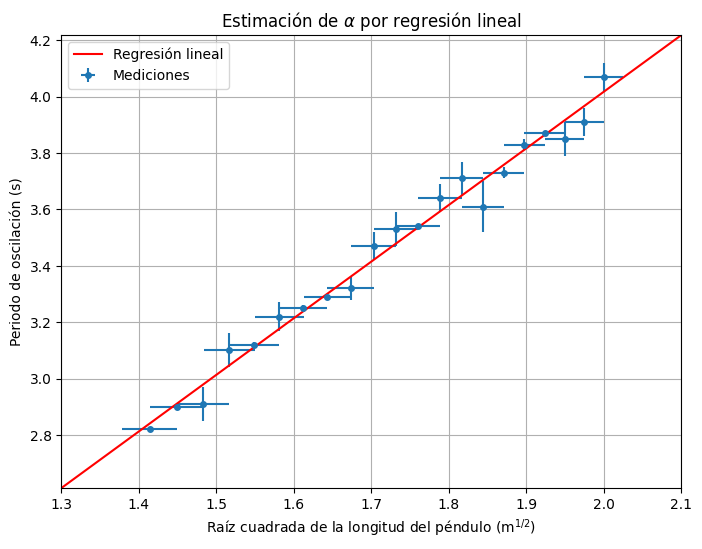

In [ ]:
x_min = 1.3
x_max = 2.1

axis = np.linspace(x_min, x_max, 100)

plt.figure(figsize=(8,6),dpi=100)
plt.errorbar(X, T, xerr=dX, yerr=dT,marker='o',  markersize=4, linestyle="None", label="Mediciones")
plt.plot(axis, TX(axis, *popt), 'r-', label="Regresión lineal")

plt.axis([x_min, x_max, TX(x_min, *popt), TX(x_max, *popt)])
plt.title('Estimación de $\\alpha$ por regresión lineal')
plt.xlabel('Raíz cuadrada de la longitud del péndulo (m$^{1/2}$)')
plt.ylabel('Periodo de oscilación (s)')

plt.grid(True)
plt.legend()
plt.show()

Por último, es fundamental que no olvides el objetivo primero que te impulsó realizar esta regresión: estimar el valor de $g$. Para ello, solo basta invertir la relación $g(\alpha)$ y propagar su incerteza de modo tal que

$$ g = \frac{4\pi^2}{\alpha^2} \;, \;\;\; \Delta g = \frac{8 \pi^2}{\alpha^3} \Delta \alpha \;,$$

para que, finalmente, puedas resolver la estimación deseada de $g\pm\Delta g$ con el siguiente bloque.

In [ ]:
g = 4*np.pi**2/popt[0]**2
dg = 8*np.pi**2*da/a**3

print('g  =',  g)
print('dg =', dg)

g  = 9.783328598318926
dg = 0.057165500730857736


## 3.3. Regresión no lineal

Siguiendo una estrategia análoga a la del ajuste lineal, es posible definir un ajuste o regresión *no lineal* que permita nuevamente estimar uno o varios parámetros para una dada relación.

Para este caso, podés volver a la relación original $T(L;g)$ no linealizada, y estimar estimar directamente el parámetro $g$ sin necesidad reescribir nuevas variables ni parámetros.

En los siguientes bloques vas a podés realizar el ajuste no lineal para la ecuación dada, estimar nuevamente el parámetro $g$ y realizar el correspondiente gráfico.

In [ ]:
def TL(L, g):
  return 2*np.pi*np.sqrt(L/g)

popt, pcov = curve_fit(TL, L, T)

g = popt[0]
dg = np.sqrt(pcov[0,0])

print('g  =',  g)
print('dg =', dg)

g  = 9.783328598490403
dg = 0.05716542940076685


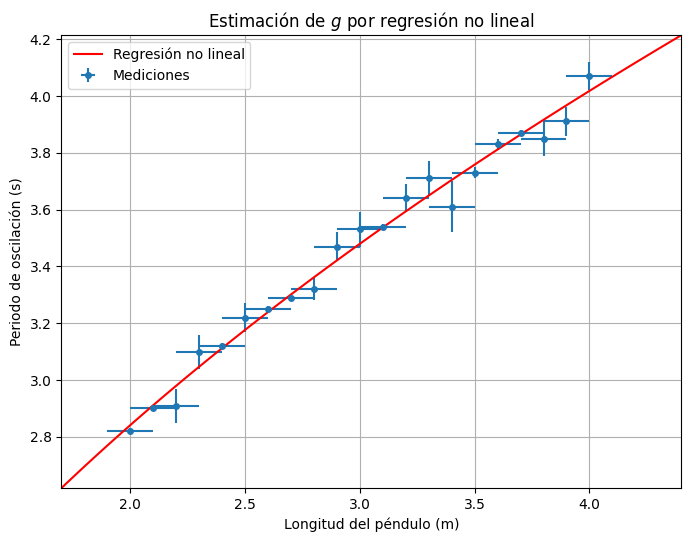

In [ ]:
x_min = 1.7
x_max = 4.4

axis = np.linspace(x_min, x_max, 100)

plt.figure(figsize=(8,6),dpi=100)
plt.errorbar(L, T, xerr=dL, yerr=dT, marker='o', markersize=4, linestyle="None", label="Mediciones")
plt.plot(axis, TL(axis, *popt), 'r-', label="Regresión no lineal")

plt.axis([x_min, x_max, TL(x_min, *popt), TL(x_max, *popt)])
plt.title('Estimación de $g$ por regresión no lineal')
plt.xlabel('Longitud del péndulo (m)')
plt.ylabel('Periodo de oscilación (s)')

plt.grid(True)
plt.legend()
plt.show()

Algo que corresponde resaltar, válido tanto en el caso lineal como no lineal, es que en el ajuste de las regresiones anteriores no se tomaron en cuenta las incertezas especificadas en cada medición. En cambio, se consideró que cada medición contribuía con el mismo *peso estadístico* a la hora de realizar el ajuste.

Otra opción posible, de la que restaría discutir en qué sentido puede ser (o no) más válida que la anterior elección, es indicarle al ajuste que considere las incertezas de cada medición. Para ello, en el bloque a continuación se repite el ajuste de siempre, con la diferencia de haber designado en `sigma` los errores de $T$ para que sean pesados en el ajuste.

In [ ]:
def TL(L, g):
  return 2*np.pi*np.sqrt(L/g)

popt, pcov = curve_fit(TL, L, T, sigma = dT)

g = popt[0]
dg = np.sqrt(pcov[0,0])

print('g  =',  g)
print('dg =', dg)

g  = 9.790777364527434
dg = 0.02294536915949592


## 3.4. Análisis de regresión

Una pregunta válida a la hora de analizar tu regresión es: ¿cuál es el poder predictivo de tu modelo?

La respuesta a esta pregunta, en principio, no es sencilla. Una forma posible de acercarse a una respuesta es contrastando modelos distintos y, luego, identificar qué modelo permitirá predecir más correctamente un nuevo conjunto de observaciones.

Otra pregunta, con una respuesta un poco más sencilla, es: ¿cuán bien tu modelo propuesto se ajusta a tus observaciones? Esto no responde estrictamente el poder predictivo de tu modelo, pero es un primer acercamiento necesario.

Siguiendo la línea de esta última pregunta, y dado un conjunto de mediciones ya realizadas, podés intentar al menos verificar cuál es la *bondad del ajuste*: cuán bien tu modelo se ajusta a tus observaciones. Esto no explica que tu modelo sea el correcto, pero sí da cuenta cuán bien tus datos se ajustan al mismo.

A modo de ejemplo, en esta guía derivamos un modelo para $T(L;g)$ dado por

$$ T_1(L;g) = \frac{2\pi}{\sqrt{g}} \sqrt{L} \; , $$

en el régimen de pequeñas oscilaciones. Sin embargo, si no hubieramos podido derivar el modelo anterior (a priori correcto) podríamos haber propuesto un modelo totalmente distinto como

$$ T_2(L;g) = \frac{7\pi}{2g} L \; , $$

tal que, por ejemplo, la relación entre el periodo y la longitud sea lineal con ordenada al origen nula.

En el bloque a continuación podés hacer, para el mismo conjunto de datos, las regresiones de ambos modelos para estimar sus parámetros, junto con los gráficos de los mismos. Como se puede observar, si bien las estimaciones parecieran ser similares a las esperadas, no así las relaciones funcionales frente a los datos: el modelo dado por $T1$ pareciera ser más predictivo.

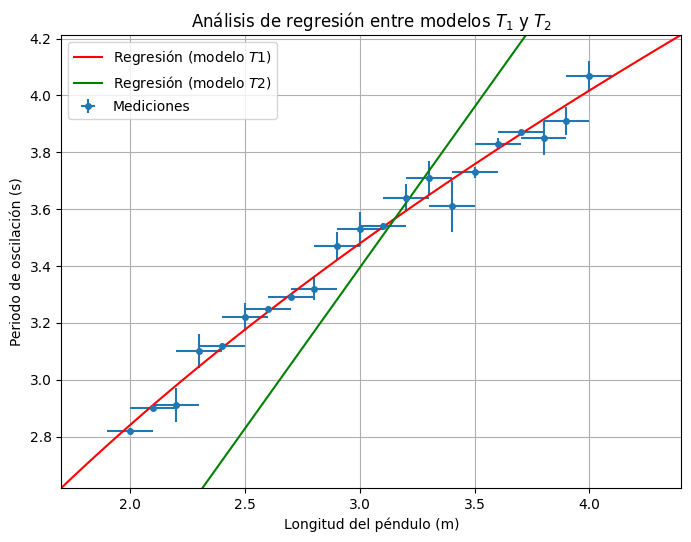

g1  = 9.783328598490403
dg1 = 0.05716542940076685
g2  = 9.718747303331606
dg2 = 0.21596872211613155


In [ ]:
def T1(L, g):
  return 2*np.pi*np.sqrt(L/g)

def T2(L, g):
  return 7*np.pi*L/2/g

popt1, pcov1 = curve_fit(T1, L, T)
popt2, pcov2 = curve_fit(T2, L, T)

g1 = popt1[0]
g2 = popt2[0]
dg1 = np.sqrt(pcov1[0,0])
dg2 = np.sqrt(pcov2[0,0])

x_min = 1.7
x_max = 4.4

axis = np.linspace(x_min, x_max, 100)

plt.figure(figsize=(8,6),dpi=100)
plt.errorbar(L, T, xerr=dL, yerr=dT, marker='o', markersize=4, linestyle="None", label="Mediciones")
plt.plot(axis, T1(axis, *popt1), 'r-', label="Regresión (modelo $T1$)")
plt.plot(axis, T2(axis, *popt2), 'g-', label="Regresión (modelo $T2$)")

plt.axis([x_min, x_max, T1(x_min, *popt), T1(x_max, *popt)])
plt.title('Análisis de regresión entre modelos $T_1$ y $T_2$')
plt.xlabel('Longitud del péndulo (m)')
plt.ylabel('Periodo de oscilación (s)')
plt.grid(True)
plt.legend()
plt.show()

print('g1  =',  g1)
print('dg1 =', dg1)
print('g2  =',  g2)
print('dg2 =', dg2)

Una forma de evaluar la bondad de un ajuste es mediante la aplicación de un *test estadístico*. Hay distintos tipos de tests, los cuales varían en su uso, destino, calidad, limitaciones, entre otros factores.

Una forma inteligente de construir un test estadístico es a partir de considerar cómo se construye la regresión usualmente: *ajuste por cuadrados mínimos*. Este procedimiento lo que busca es encontrar el mínimo valor posible de la *suma de los cuadrados de los residuos*

$$ \textrm{RSS} = \sum_{i=1}^N (y_i-\hat{y}_i)^2 \;,$$

donde $y_i$ son cada uno de los $N$ valores observados y $f(x_i):=\hat{y_i}$ son los valores del modelo que estamos ajustando. Luego, este algoritmo o procedimiento, buscará los parámetros del modelo (en nuestro ejemplo $g$) tal que la RSS sea mínima.

Un test muy difundido, que se favorece del propio procedimiento de ajuste, es el denominado *Test $\chi^2$ (chi cuadrado) de Pearson* con estadístico

$$ \chi^2_\textrm{Pearson} = \sum_{i=1}^N \frac{(y_i-\hat{y}_i)^2}{\hat{y}_i} \;.$$

Otro test, que sigue el mismo espíritu, es el *Test $\chi^2_\nu$ Reducido*, cuyo estadístico es

$$ \chi^2_\nu = \frac{1}{\nu} \sum_{i=1}^N \frac{(y_i-\hat{y})^2}{\sigma_i^2} \;, \;\;\; \nu=N-m \;, $$

donde $\sigma_i$ son las incertezas correspondientes a cada $y_i$; y $\nu$ el número de grados de libertad, calculado como la diferencia entre el número total de observaciones $(N)$ y el número total de parámetros que se ajustarón $(m)$.

Por razones históricas, en muchas disciplinas se suele mencionar también el *coeficiente de determinación*

$$ R^2 = 1 - \frac{\sum (y_i-\hat{y}_i)^2}{\sum (y_i-\bar{y})^2} \;,$$

donde $\bar{y}$ es el promedio de los valores observados. Cabe destacar que el mismo no explica la bondad de una regresión (ni siquiera en un caso lineal); en cambio, el $R^2$ explica la correlación entre variables observadas y teóricas (es decir, si son 1:1), y su utilidad real frente a otros estadísticos es ampliamente discutida (https://data.library.virginia.edu/is-r-squared-useless/).

En el bloque a continuación incluimos tres estadísticos discutidos: el $\chi^2$ (chi cuadrado) de Pearson; el $\chi^2_\nu$ reducido; y el coeficiente de determinación $R^2$.

In [ ]:
def pearson_chi_sq(y, f):
  # https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test
  return np.sum((y-f)**2/f)

def reduced_chi_sq(y, f, sd, m):
  # https://en.wikipedia.org/wiki/Reduced_chi-squared_statistic
  return np.sum(((y-f)/sd)**2) / (len(y)-m)

def r_sq(y, f):
  # https://en.wikipedia.org/wiki/Coefficient_of_determination
  rss = np.sum((y-f)**2)
  tss = np.sum((y-np.mean(y))**2)
  return 1 - rss/tss
  # the following not always holds true
  # ess = np.sum((f-np.mean(y))**2)
  # return ess/tss

Para evaluar la bondad del ajuste recomendamos utilizar el $\chi^2_\nu$ reducido, ya que el mismo resulta más sencillo de interpretar. Para este test en particular, se pueden seguir las siguientes reglas: si $\chi^2_\nu\gg1$, el modelo propuesto es pobre; si $\chi^2_\nu>1$, el modelo es compatible con las observaciones pero habría una subestimación de las incertezas; si $\chi^2_\nu<1$, el modelo es compatible pero habría una sobreestimación de las incertezas.

Cuando hablamos de subestimar incertezas nos referimos, en cierto sentido, a que las barras de error se superponen con la curva teórica menos veces de lo esperado; contrariamente, sobreestimar las incertezas implica que las barras de error se superponen con la curva teórica más veces de lo esperado. Una simulación útil para entender estos conceptos se puede encontrar en https://phet.colorado.edu/en/simulation/curve-fitting

Entonces, como regla general, lo que se busca idealmente es que $\chi^2_\nu=1$; es decir, que no haya ni subestimación ni sobreestimación de las incertezas.

En el bloque a continuación se realiza el test $\chi^2_\nu$ reducido para los dos modelos propuestos $T_1$ y $T_2$, en cada uno haciendo uso de los valores de $g_1$ y $g_2$ obtenidos en cada respectiva regresión. Puede observase que el primer modelo $T_1$ tiene un $\chi^2_\nu\approx 1$, por lo que el modelo es compatible con las observaciones (aunque presenta leve subestimación); mientras que el modelo $T_2$ tiene $\chi^2_\nu\gg 1$, por lo que el modelo resulta pobre e incompatible con las observaciones.

In [ ]:
test_modelo_1 = reduced_chi_sq(T,T1(L,g1),dT,1)
test_modelo_2 = reduced_chi_sq(T,T2(L,g2),dT,1)

print('Test Chi-Sq reducido (modelo 1): ', test_modelo_1)
print('Test Chi-Sq reducido (modelo 2): ', test_modelo_2)

Test Chi-Sq reducido (modelo 1):  1.2054059466193503
Test Chi-Sq reducido (modelo 2):  537.233144876077


> *Documento elaborado por Adán Garros (adan@garros.net) bajo licencia [CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/deed.es). Se agradece especialmente a Verónica Pérez Schuster por la revisión del contenido. Resultan bienvenidos comentarios y sugerencias. Última actualización: 2021-10-01.*